# 0. Import libraries

In [1]:
import pandas as pd
!pip install langdetect
from langdetect import detect

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#1. Load data

In [2]:
# merging 

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#path = '/content/gdrive/MyDrive/Colab Notebooks/18_projekt_końcowy/01_Data/twitter-sentiment-analysis.csv'
#path = './twitter-sentiment-analysis.csv'
#path = '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/dataset/twitter-sentiment-analysis.csv'

%cd gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/dataset/
!ls
df_columns=['group','id','date','flag','user_name','text']
df_encoding = "ISO-8859-1"
df = pd.read_csv("twitter-sentiment-analysis.csv", encoding=df_encoding, names=df_columns)
df.head(10)

/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/dataset
twitter-sentiment-analysis.csv	twitter-sentiment-analysis-language.csv


,group,id,date,flag,user_name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


#2. Exploration of data

## (0) General

In [4]:
# checking the number of rows in the dataset
len(df)

1600000

In [5]:
# checking the shape of the dataset
df.shape

(1600000, 6)

In [6]:
# checking df into for non-null values anf data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   group      1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user_name  1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
# checking if columns contain null values
df.isnull().sum()

group        0
id           0
date         0
flag         0
user_name    0
text         0
dtype: int64

##(1) Dates

In [8]:
# changing original date format to datetime
# Example: from 'Mon Apr 06 22:19:45 PDT 2009' to 2009-04-06 22:19:45
df['datetime'] = pd.to_datetime(df['date'])

# changing datetime to diffrent formats
df['year-month-day'] = pd.to_datetime(df['datetime']).dt.date.astype(str)
df['year-month'] = df['datetime'].dt.to_period('M').astype(str)
df['month'] = df['year-month'].replace({'2009-04': 'April', '2009-05': 'May', '2009-06': 'June'})
df['day_of_week'] = df['datetime'].dt.day_name().astype(str)

df.head(10)

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,group,id,date,flag,user_name,text,datetime,year-month-day,year-month,month,day_of_week
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009-04-06,2009-04,April,Monday
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009-04-06,2009-04,April,Monday
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009-04-06,2009-04,April,Monday
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009-04-06,2009-04,April,Monday
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009-04-06,2009-04,April,Monday
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,2009-04-06 22:20:00,2009-04-06,2009-04,April,Monday
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug,2009-04-06 22:20:03,2009-04-06,2009-04,April,Monday
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,2009-04-06 22:20:03,2009-04-06,2009-04,April,Monday
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it,2009-04-06 22:20:05,2009-04-06,2009-04,April,Monday
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?,2009-04-06 22:20:09,2009-04-06,2009-04,April,Monday


In [9]:
# checking max and min of tweets date and time range
print(f'Start date:\t{min(df["datetime"])}')
print(f'Stop date:\t{max(df["datetime"])}')

Start date:	2009-04-06 22:19:45
Stop date:	2009-06-25 10:28:31


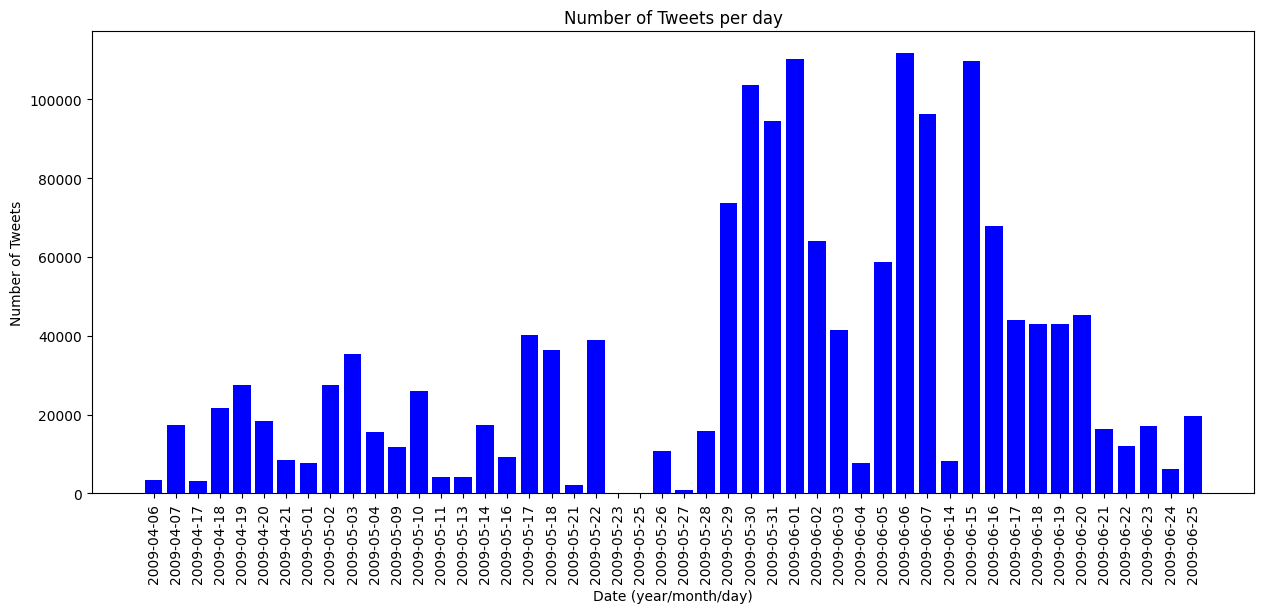

In [10]:
def groupby_column(df,column):
  groupby=df.groupby(column)
  return {x:groupby.get_group(x) for x in groupby.groups}

all_days=groupby_column(df,'year-month-day')

fig,ax=plt.subplots(figsize=(15,6))
for day in all_days.keys():
    ax.bar(day,all_days[day]['group'].count(), color='b')

ax.set_xlabel('Date (year/month/day)')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Number of Tweets')

ax.set_title('Number of Tweets per day')
plt.show()

In [11]:
del all_days

In [17]:
# grouping tweets by month
df_grouped_by_month = df.groupby(['month']).count()
df_grouped_by_month = df_grouped_by_month[['group']]
df_grouped_by_month = df_grouped_by_month.rename(columns={'group': 'number of tweets'})
df_grouped_by_month.reset_index(inplace=True)

cats = ['April', 'May', 'June']
df_grouped_by_month['month'] = pd.Categorical(df_grouped_by_month['month'], categories=cats, ordered=True)
df_grouped_by_month = df_grouped_by_month.sort_values('month')

df_grouped_by_month = df_grouped_by_month.set_index('month')

df_grouped_by_month

,number of tweets
month,
April,100025
May,576367
June,923608


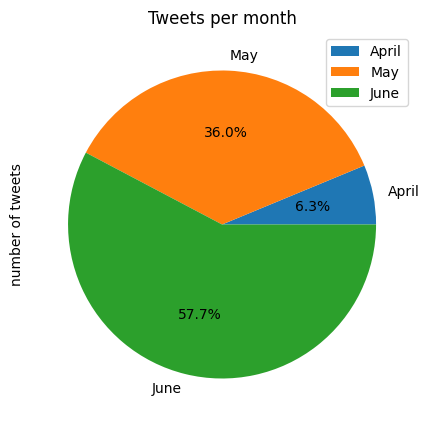

In [18]:
plot = df_grouped_by_month.plot.pie(y='number of tweets', title='Tweets per month', autopct='%1.1f%%', figsize=(5, 5))

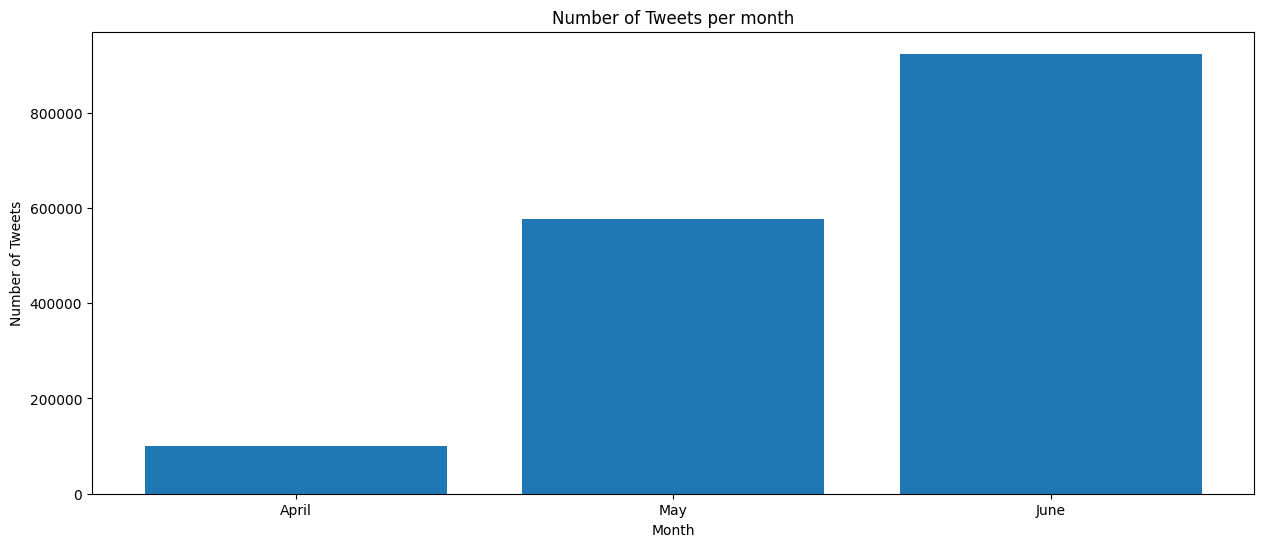

In [22]:
fig,ax=plt.subplots(figsize=(15,6))
ax.bar(df_grouped_by_month.index, df_grouped_by_month['number of tweets'])

ax.set_xlabel('Month')
ax.set_ylabel('Number of Tweets')

ax.set_title('Number of Tweets per month')
plt.show()

In [24]:
del df_grouped_by_month

In [25]:
# grouping tweets by day of week
df_grouped_by_day_of_week = df.groupby(['day_of_week']).count()
df_grouped_by_day_of_week = df_grouped_by_day_of_week[['group']]
df_grouped_by_day_of_week = df_grouped_by_day_of_week.rename(columns={'group': 'number of tweets'})
df_grouped_by_day_of_week.reset_index(inplace=True)

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_grouped_by_day_of_week['day_of_week'] = pd.Categorical(df_grouped_by_day_of_week['day_of_week'], categories=cats, ordered=True)
df_grouped_by_day_of_week = df_grouped_by_day_of_week.sort_values('day_of_week')

df_grouped_by_day_of_week

,day_of_week,number of tweets
1,Monday,310205
5,Tuesday,185850
6,Wednesday,96806
4,Thursday,106035
0,Friday,225594
2,Saturday,330955
3,Sunday,344555


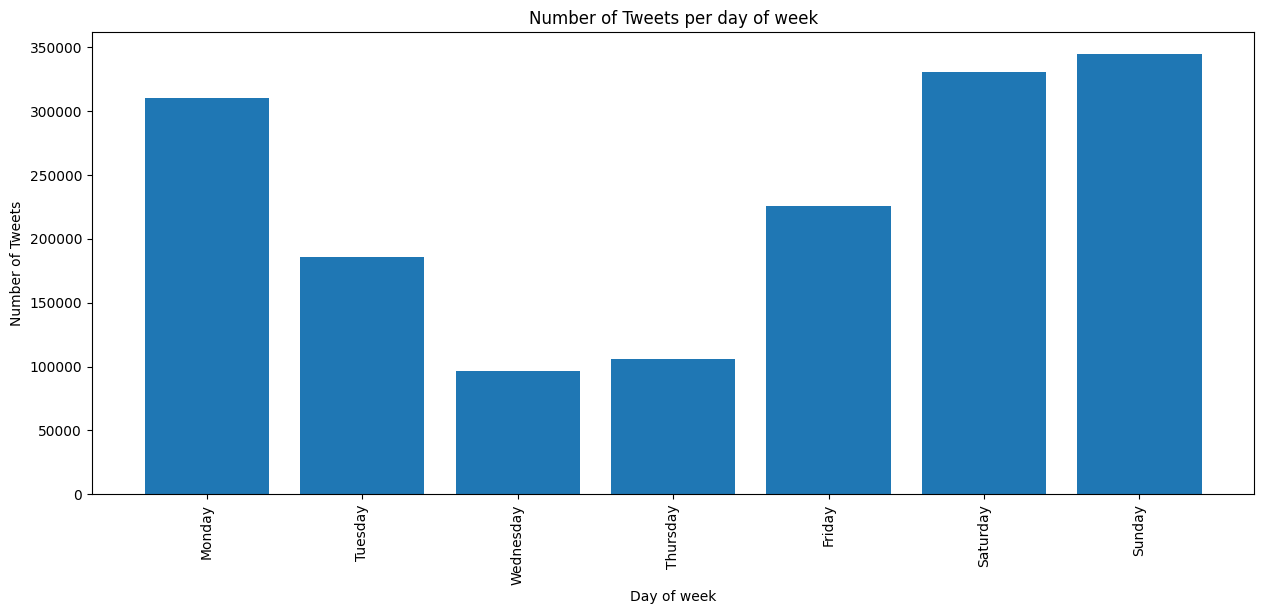

In [26]:
fig,ax=plt.subplots(figsize=(15,6))
ax.bar(df_grouped_by_day_of_week['day_of_week'], df_grouped_by_day_of_week['number of tweets'])

ax.set_xlabel('Day of week')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Number of Tweets')

ax.set_title('Number of Tweets per day of week')
plt.show()

In [27]:
del df_grouped_by_day_of_week

##(2) Groups

In [28]:
# checking unique values of group column
uniqueValues = df['group'].unique()
print(uniqueValues)

[0 4]


In [29]:
df['group_name'] = df['group'].replace({0: 'negative', 4: 'positive'})
df

,group,id,date,flag,user_name,text,datetime,year-month-day,year-month,month,day_of_week,group_name
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009-04-06,2009-04,April,Monday,negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009-04-06,2009-04,April,Monday,negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009-04-06,2009-04,April,Monday,negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009-04-06,2009-04,April,Monday,negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009-04-06,2009-04,April,Monday,negative
...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,2009-06-16 08:40:49,2009-06-16,2009-06,June,Tuesday,positive
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,2009-06-16 08:40:49,2009-06-16,2009-06,June,Tuesday,positive
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,2009-06-16 08:40:49,2009-06-16,2009-06,June,Tuesday,positive
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,2009-06-16 08:40:49,2009-06-16,2009-06,June,Tuesday,positive


In [30]:
# grouping tweets by positive and negative
df_groups = df.groupby(['group_name']).count()
df_groups = df_groups[['group']]
df_groups = df_groups.rename(columns={'group': 'number of tweets'})
df_groups

,number of tweets
group_name,
negative,800000
positive,800000


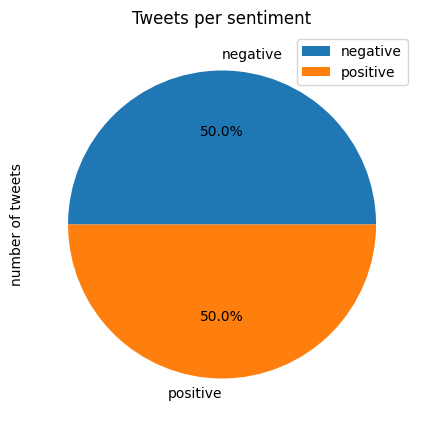

In [31]:
plot = df_groups.plot.pie(y='number of tweets', title='Tweets per sentiment', autopct='%1.1f%%', figsize=(5, 5))

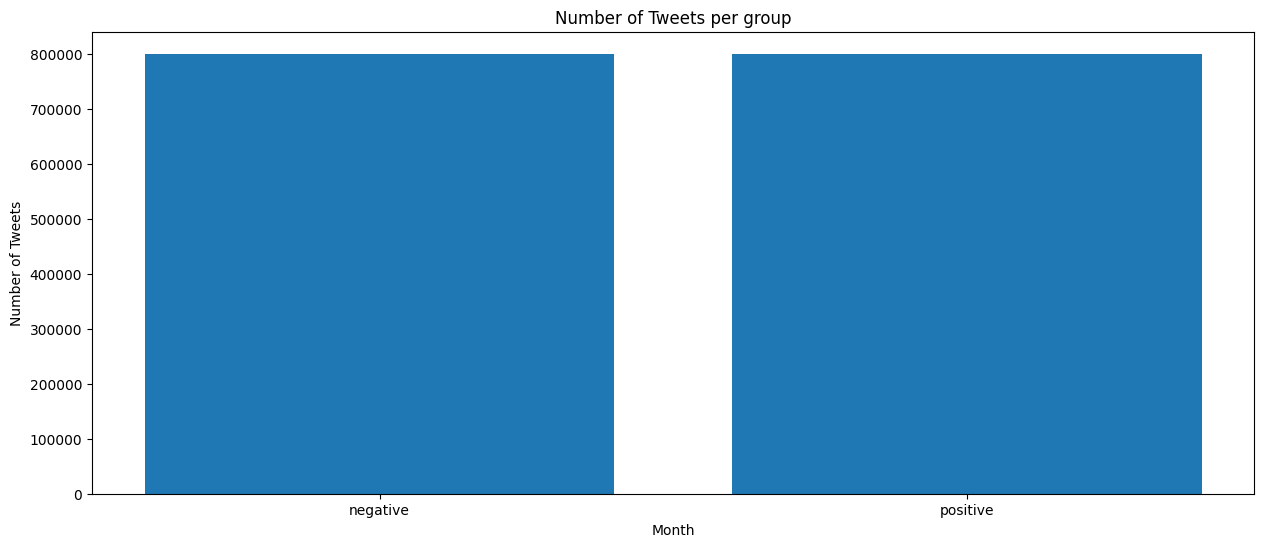

In [33]:
fig,ax=plt.subplots(figsize=(15,6))
ax.bar(df_groups.index, df_groups['number of tweets'])

ax.set_xlabel('Month')
ax.set_ylabel('Number of Tweets')

ax.set_title('Number of Tweets per group')
plt.show()

In [34]:
del df_groups

In [35]:
# grouping tweets by day of week
df_grouped_by_day_of_week = df.groupby(['day_of_week', 'group_name']).count()
df_grouped_by_day_of_week = df_grouped_by_day_of_week[['group']]
df_grouped_by_day_of_week = df_grouped_by_day_of_week.rename(columns={'group': 'number of tweets'})
df_grouped_by_day_of_week.reset_index(inplace=True)

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_grouped_by_day_of_week['day_of_week'] = pd.Categorical(df_grouped_by_day_of_week['day_of_week'], categories=cats, ordered=True)
df_grouped_by_day_of_week = df_grouped_by_day_of_week.sort_values('day_of_week')

df_grouped_by_day_of_week['share'] = df_grouped_by_day_of_week['number of tweets']/df_grouped_by_day_of_week.groupby(['day_of_week'])['number of tweets'].transform('sum')
df_grouped_by_day_of_week

,day_of_week,group_name,number of tweets,share
2,Monday,negative,132539,0.427263
3,Monday,positive,177666,0.572737
10,Tuesday,negative,101051,0.543723
11,Tuesday,positive,84799,0.456277
12,Wednesday,negative,68473,0.707322
13,Wednesday,positive,28333,0.292678
8,Thursday,negative,80132,0.755713
9,Thursday,positive,25903,0.244287
0,Friday,negative,114600,0.507992
1,Friday,positive,110994,0.492008


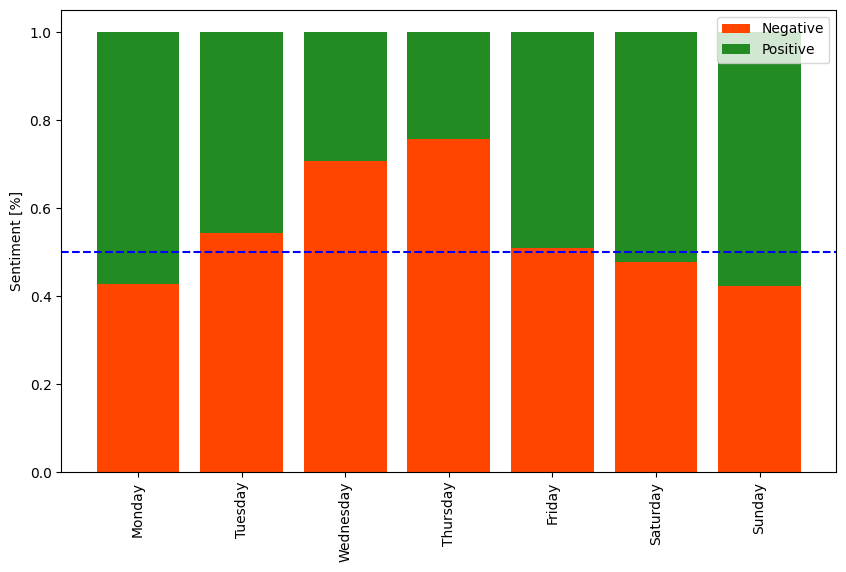

In [36]:
grouped_neg = df_grouped_by_day_of_week[df_grouped_by_day_of_week['group_name']=='negative']
grouped_pos = df_grouped_by_day_of_week[df_grouped_by_day_of_week['group_name']=='positive']

fig,ax=plt.subplots(figsize=(10,6))
ax.bar(grouped_neg['day_of_week'], grouped_neg['share'], label='Negative', color='orangered')
ax.bar(grouped_pos['day_of_week'], grouped_pos['share'], label='Positive', color='forestgreen',bottom=grouped_neg['share'])
plt.axhline(y=0.5,color='b',linestyle='--')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Sentiment [%]')
ax.legend()
plt.show()

In [37]:
del df_grouped_by_day_of_week

In [38]:
# grouping tweets by month
df_grouped_by_month = df.groupby(['month', 'group_name']).count()
df_grouped_by_month = df_grouped_by_month[['group']]
df_grouped_by_month = df_grouped_by_month.rename(columns={'group': 'number of tweets'})
df_grouped_by_month.reset_index(inplace=True)

cats = ['April', 'May', 'June']
df_grouped_by_month['month'] = pd.Categorical(df_grouped_by_month['month'], categories=cats, ordered=True)
df_grouped_by_month = df_grouped_by_month.sort_values('month')

df_grouped_by_month['share'] = df_grouped_by_month['number of tweets']/df_grouped_by_month.groupby(['month'])['number of tweets'].transform('sum')
df_grouped_by_month

df_grouped_by_month

,month,group_name,number of tweets,share
0,April,negative,41607,0.415966
1,April,positive,58418,0.584034
4,May,negative,224822,0.390067
5,May,positive,351545,0.609933
2,June,negative,533571,0.577703
3,June,positive,390037,0.422297


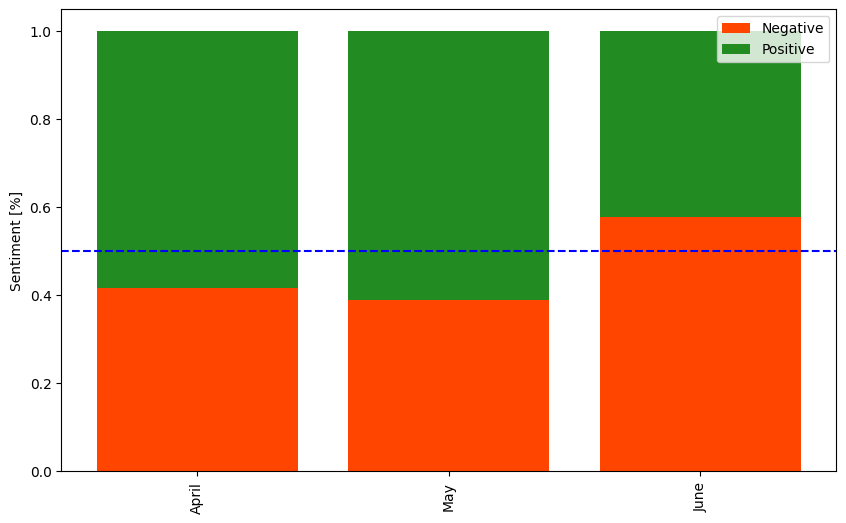

In [39]:
grouped_neg = df_grouped_by_month[df_grouped_by_month['group_name']=='negative']
grouped_pos = df_grouped_by_month[df_grouped_by_month['group_name']=='positive']

fig,ax=plt.subplots(figsize=(10,6))
ax.bar(grouped_neg['month'], grouped_neg['share'], label='Negative', color='orangered')
ax.bar(grouped_pos['month'], grouped_pos['share'], label='Positive', color='forestgreen',bottom=grouped_neg['share'])
plt.axhline(y=0.5,color='b',linestyle='--')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Sentiment [%]')
ax.legend()
plt.show()

In [40]:
del df_grouped_by_month
del grouped_neg
del grouped_pos

##(3) Flags

In [41]:
# counting unique elements of flag columns
df['flag'].unique()

array(['NO_QUERY'], dtype=object)

## (4) User Names

In [42]:
#counting unique user names
print(len(df['user_name'].unique()))

659775


In [43]:
# searching for the most active user
df.groupby(['user_name']).count().sort_values(by='id', ascending=False)

,group,id,date,flag,text,datetime,year-month-day,year-month,month,day_of_week,group_name
user_name,,,,,,,,,,,
lost_dog,549,549,549,549,549,549,549,549,549,549,549
webwoke,345,345,345,345,345,345,345,345,345,345,345
tweetpet,310,310,310,310,310,310,310,310,310,310,310
SallytheShizzle,281,281,281,281,281,281,281,281,281,281,281
VioletsCRUK,279,279,279,279,279,279,279,279,279,279,279
...,...,...,...,...,...,...,...,...,...,...,...
artgantuan,1,1,1,1,1,1,1,1,1,1,1
artfulife,1,1,1,1,1,1,1,1,1,1,1
artful_Roger,1,1,1,1,1,1,1,1,1,1,1


In [46]:
df_pos = df[df['group_name']=='positive']
df_pos = df_pos.groupby(['user_name']).count().sort_values(by='id', ascending=False)
df_pos = df_pos[['group']]
df_pos = df_pos.rename(columns={'group': 'number_of_tweets'})
df_pos = df_pos.sort_values(by='number_of_tweets', ascending=False)
df_pos.reset_index(inplace=True)
df_pos

,user_name,number_of_tweets
0,what_bugs_u,246
1,DarkPiano,231
2,VioletsCRUK,218
3,tsarnick,212
4,keza34,211
...,...,...
376564,varsharavi,1
376565,varsharavichhh,1
376566,varshashastri,1
376567,Keatii_0x,1


In [45]:
df_neg = df[df['group_name']=='negative']
df_neg = df_neg.groupby(['user_name']).count().sort_values(by='id', ascending=False)
df_neg = df_neg[['group']]
df_neg = df_neg.rename(columns={'group': 'number_of_tweets'})
df_neg = df_neg.sort_values(by='number_of_tweets', ascending=False)
df_neg.reset_index(inplace=True)
df_neg

,user_name,number_of_tweets
0,lost_dog,549
1,tweetpet,310
2,webwoke,264
3,mcraddictal,210
4,wowlew,210
...,...,...
415666,raelee88,1
415667,raekristine10,1
415668,raeireland,1
415669,raeindira,1


In [48]:
df_users = pd.DataFrame(df['user_name'].unique(), columns=['user_name'])
step_1_df = pd.merge(df_users, df_pos, how='left', on='user_name')
step_1_df = step_1_df.rename(columns={'number_of_tweets': 'positive_tweets'})
result = pd.merge(step_1_df, df_neg, how='left', on='user_name')
result = result.rename(columns={'number_of_tweets': 'negative_tweets'})

result['positive_tweets'] = result['positive_tweets'].fillna(0)
result['negative_tweets'] = result['negative_tweets'].fillna(0)
result['all_tweets'] = result['positive_tweets'] + result['negative_tweets']
result['positive_prc'] = result['positive_tweets']  / result['all_tweets']
result['negative_prc'] = result['negative_tweets']  / result['all_tweets']
result = result.sort_values(by='all_tweets', ascending=False)
result

,user_name,positive_tweets,negative_tweets,all_tweets,positive_prc,negative_prc
36990,lost_dog,0.0,549.0,549.0,0.000000,1.000000
224047,webwoke,81.0,264.0,345.0,0.234783,0.765217
8815,tweetpet,0.0,310.0,310.0,0.000000,1.000000
103921,SallytheShizzle,98.0,183.0,281.0,0.348754,0.651246
2344,VioletsCRUK,218.0,61.0,279.0,0.781362,0.218638
...,...,...,...,...,...,...
323897,67trinity,0.0,1.0,1.0,0.000000,1.000000
323896,Sibby,0.0,1.0,1.0,0.000000,1.000000
323894,mAnyA_15,0.0,1.0,1.0,0.000000,1.000000
323893,49ersfan111,0.0,1.0,1.0,0.000000,1.000000


In [49]:
print('Mean tweet number per unique user:\t\t\t', result['all_tweets'].mean())
print('Mean POSITIVE tweet number per unique user:\t\t', result['positive_tweets'].mean())
print('Mean POSITIVE % of tweet numbers per unique user:\t', result['positive_prc'].mean())
print('Mean NEGATIVE tweet number per unique user:\t\t', result['negative_tweets'].mean())
print('Mean NEGATIVE % of tweet numbers per unique user:\t', result['negative_prc'].mean())

neg_res = result.sort_values(by='negative_tweets', ascending=False)
print(neg_res.head(1))

pos_res = result.sort_values(by='positive_tweets', ascending=False)
print(pos_res.head(1))

Mean tweet number per unique user:			 2.425069152362548
Mean POSITIVE tweet number per unique user:		 1.212534576181274
Mean POSITIVE % of tweet numbers per unique user:	 0.47015779905257543
Mean NEGATIVE tweet number per unique user:		 1.212534576181274
Mean NEGATIVE % of tweet numbers per unique user:	 0.5298422009474246
      user_name  positive_tweets  negative_tweets  all_tweets  positive_prc  \
36990  lost_dog              0.0            549.0       549.0           0.0   

       negative_prc  
36990           1.0  
          user_name  positive_tweets  negative_tweets  all_tweets  \
539514  what_bugs_u            246.0              0.0       246.0   

        positive_prc  negative_prc  
539514           1.0           0.0  


In [51]:
del neg_res
del pos_res
del df_users
del step_1_df
del result

## (5) Text

In [52]:
text_df = df[['user_name', 'group_name', 'text']]
text_df['text_len'] = text_df['text'].str.len()
print(text_df['text_len'].mean())
print(text_df['text_len'].max())
print(text_df['text_len'].min())
text_df

74.09011125
374
6


<ipython-input-52-145ca1356b34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text_len'] = text_df['text'].str.len()


,user_name,group_name,text,text_len
0,_TheSpecialOne_,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,scotthamilton,negative,is upset that he can't update his Facebook by ...,111
2,mattycus,negative,@Kenichan I dived many times for the ball. Man...,89
3,ElleCTF,negative,my whole body feels itchy and like its on fire,47
4,Karoli,negative,"@nationwideclass no, it's not behaving at all....",111
...,...,...,...,...
1599995,AmandaMarie1028,positive,Just woke up. Having no school is the best fee...,56
1599996,TheWDBoards,positive,TheWDB.com - Very cool to hear old Walt interv...,78
1599997,bpbabe,positive,Are you ready for your MoJo Makeover? Ask me f...,57
1599998,tinydiamondz,positive,Happy 38th Birthday to my boo of alll time!!! ...,65


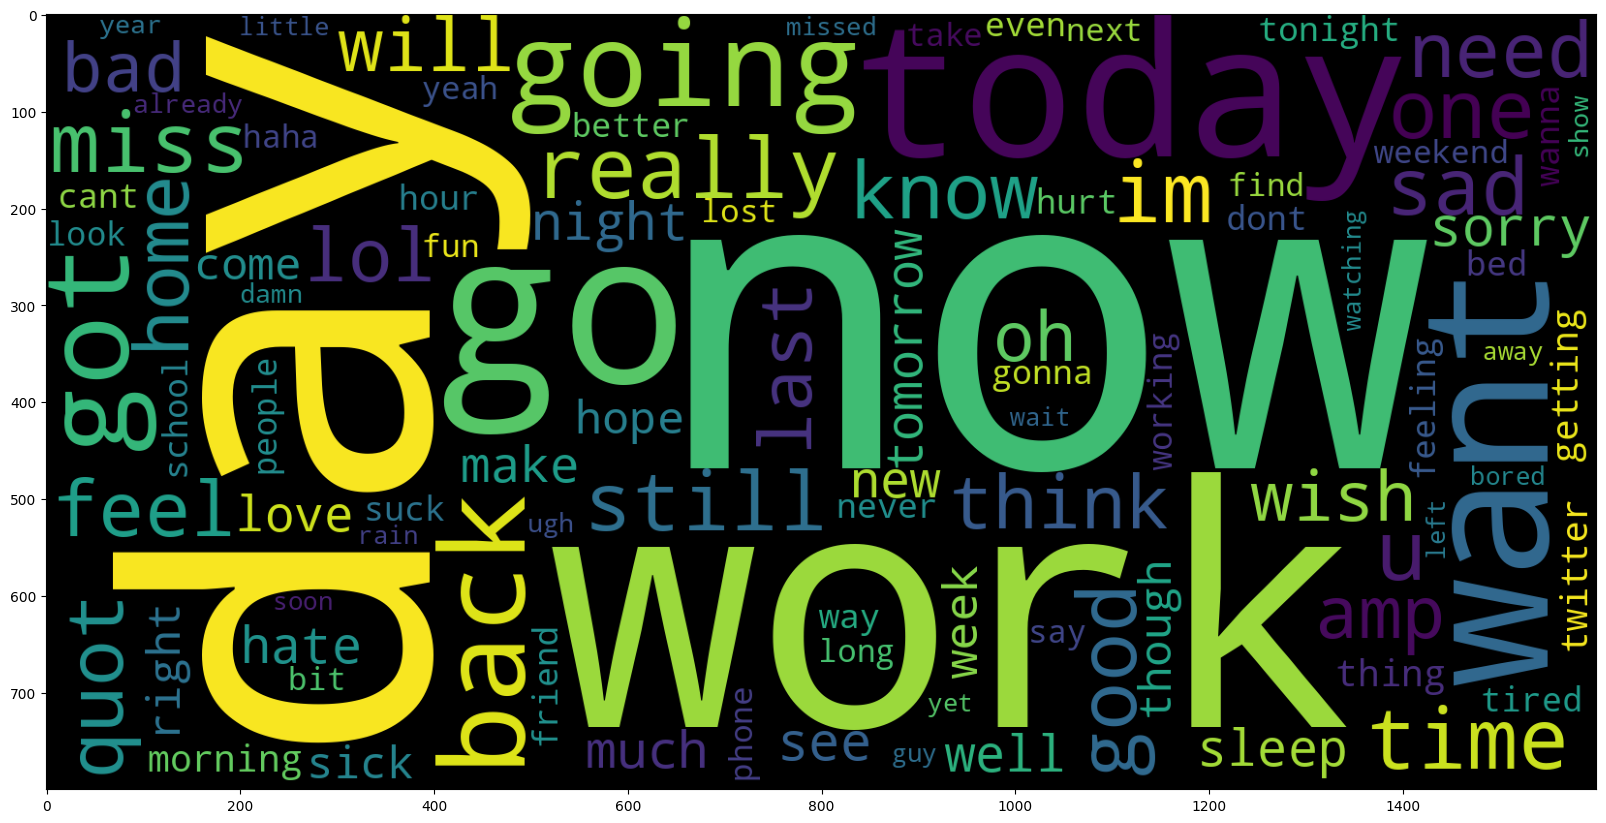

In [53]:
# NEGATIVE WORDS
df_neg = df[df['group_name']=='negative']
data_neg = df_neg['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

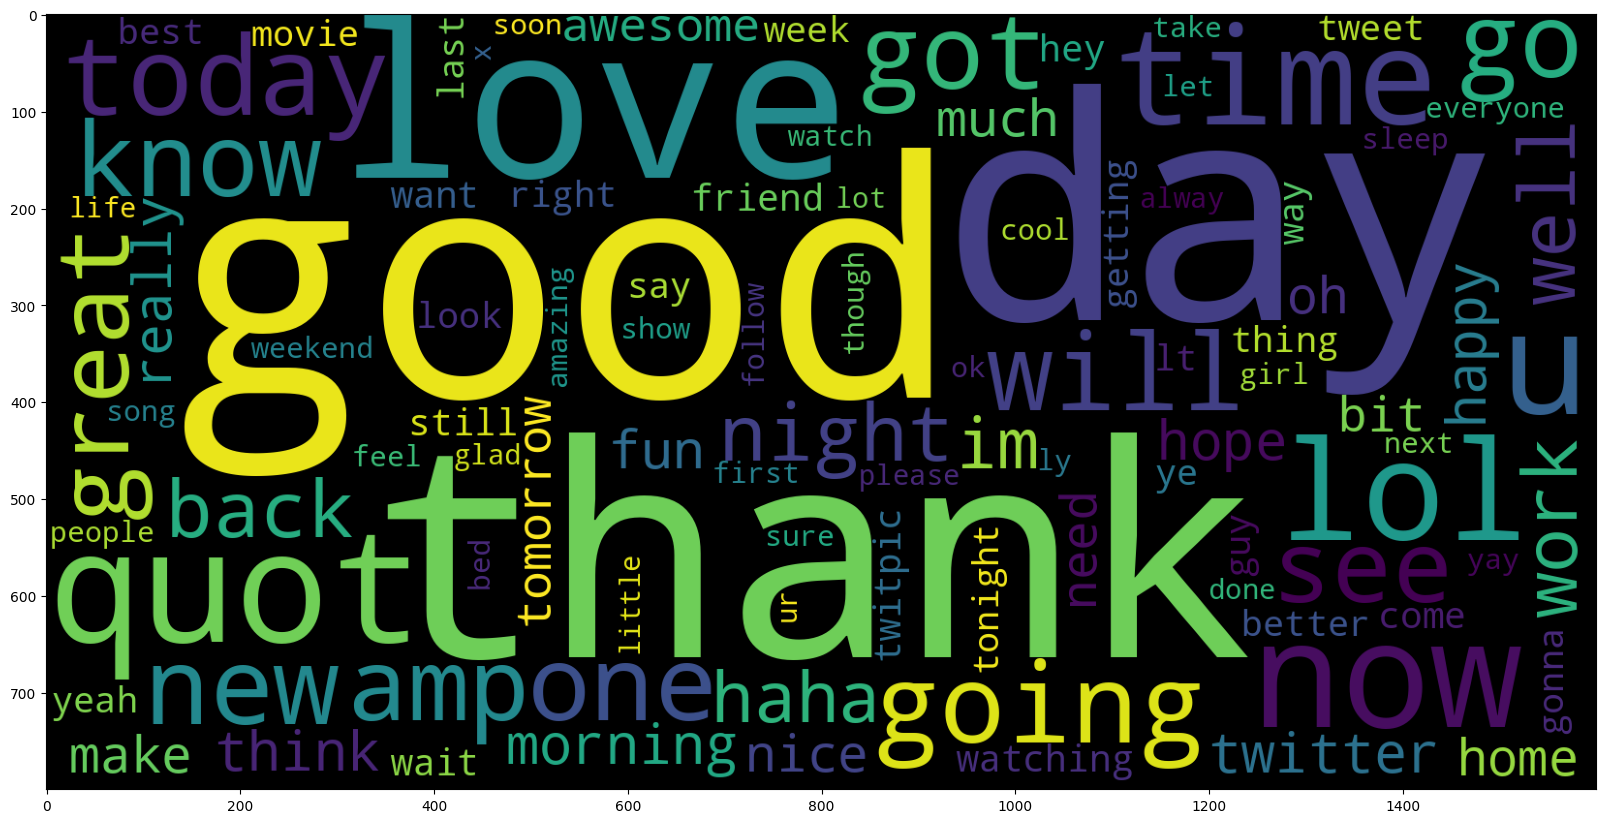

In [54]:
# POSITIVE WORDS
df_pos = df[df['group_name']=='positive']
data_pos = df_pos['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

#3. Data preparation and cleaning

##Step 1: Keep only important for modelling columns

In [4]:
new_df = df[['group', 'text']]
new_df.head(10)

,group,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


##Step 2: Change Target values ("group") to 0 and 1

In [5]:
# replacing 4 with 1 for positive values in group column
new_df['group'] = new_df['group'].replace(4,1)

uniqueValues = new_df['group'].unique()
print(uniqueValues)

[0 1]


<ipython-input-5-4928d61d6316>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['group'] = new_df['group'].replace(4,1)


##Step 3: Delete  urls, numbers and user names from **tweets**

###urls - functions

In [6]:
def remove_urls(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

class RemoveUrlTrasformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_urls(x))
        return X_

###numbers - functions

In [7]:
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)

class RemoveNumbersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_numbers(x))
        return X_

###user name - functions

In [8]:
def remove_usernames(data):
    return re.sub('@\w+', '', data)

class RemoveUserNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_usernames(x))
        return X_

###Pipeline: Run deleting urls, numbers, user name

In [9]:
pipe1 = Pipeline(
    [('remove_urls', RemoveUrlTrasformer(text_column='text')),
    ('remove_numbers', RemoveNumbersTransformer(text_column='text')),
    ('remove_usernames', RemoveUserNamesTransformer(text_column='text'))])


df_pipe1 = pipe1.fit_transform(new_df)
del df
df_pipe1.head(10)

,group,text
0,0,s a bummer. You shoulda got David Carr of T...
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."
5,0,not the whole crew
6,0,Need a hug
7,0,"hey long time no see! Yes.. Rains a bit ,onl..."
8,0,nope they didn't have it
9,0,que me muera ?


##Step 4: Language detection and delete not-english **tweets**

In [ ]:
'''WARNING: As the code runs quite slow, we decided to save output as new csv file '''
# loop for detenting languages in the file
languages = []
for text in df_pipe1['text']:
    try:
        language = detect(text)
    except:
        language = 'unknown'
    languages.append(language)

df_pipe1['language'] = languages

lang_path = '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/dataset/twitter-sentiment-analysis-language.csv'
df_pipe1.to_csv(lang_path)

df_pipe1.head(10)

In [10]:
'''Uncomment and run this code if you want to skip processing language detection 
and upload ready dataset with language'''

path = '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/dataset/twitter-sentiment-analysis-language.csv'
df_encoding = "ISO-8859-1"
df_pipe1 = pd.read_csv(path, encoding=df_encoding)
df_pipe1 = df_pipe1[['group', 'text', 'language']]
df_pipe1.head(10)

,group,text,language
0,0,s a bummer. You shoulda got David Carr of T...,en
1,0,is upset that he can't update his Facebook by ...,en
2,0,I dived many times for the ball. Managed to s...,en
3,0,my whole body feels itchy and like its on fire,en
4,0,"no, it's not behaving at all. i'm mad. why am...",en
5,0,not the whole crew,en
6,0,Need a hug,en
7,0,"hey long time no see! Yes.. Rains a bit ,onl...",en
8,0,nope they didn't have it,en
9,0,que me muera ?,ca


In [ ]:
df_pipe1['language'].unique()

array(['en', 'ca', 'tl', 'it', 'da', 'pl', 'af', 'hr', 'un', 'pt', 'cy',
       'et', 'fr', 'nl', 'ro', 'no', 'es', 'id', 'sv', 'sk', 'sq', 'so',
       'de', 'fi', 'cs', 'hu', 'vi', 'sl', 'sw', 'lv', 'tr', 'lt', 'uk',
       'ko', 'zh-cn'], dtype=object)

In [ ]:
df_pipe1['language'].value_counts()

en       1464303
so         19510
af         18208
cy         10186
tl          9519
nl          7573
no          6871
fr          6715
un          6299
id          5172
et          4317
de          3998
it          3895
da          3851
ca          3653
sv          2884
pt          2289
pl          2178
fi          1996
ro          1939
es          1672
tr          1648
sw          1613
vi          1602
hu          1561
hr          1468
sq          1407
cs          1310
sk          1026
sl           948
lv           198
lt           125
zh-cn         28
ko            27
uk            11
Name: language, dtype: int64

###Visualization: Language

In [11]:
df_grouped_by_lang = df_pipe1.groupby(['language']).count()
df_grouped_by_lang = df_grouped_by_lang[['group']]
df_grouped_by_lang = df_grouped_by_lang.rename(columns={'group': 'number_of_tweets'})
df_grouped_by_lang = df_grouped_by_lang.sort_values(by='number_of_tweets', ascending=False)
df_grouped_by_lang.reset_index(inplace=True)
df_grouped_by_lang

,language,number_of_tweets
0,en,1464303
1,so,19510
2,af,18208
3,cy,10186
4,tl,9519
5,nl,7573
6,no,6871
7,fr,6715
8,un,6299
9,id,5172


In [12]:
df_grouped_total_lang = pd.DataFrame()
df_grouped_total_lang['lang'] = ['en', 'not-en']
df_grouped_total_lang['sum'] = [df_grouped_by_lang['number_of_tweets'][df_grouped_by_lang['language']=='en'].sum(), df_grouped_by_lang['number_of_tweets'][df_grouped_by_lang['language']!='en'].sum()]
df_grouped_total_lang = df_grouped_total_lang.set_index('lang')
df_grouped_total_lang

,sum
lang,
en,1464303
not-en,135697


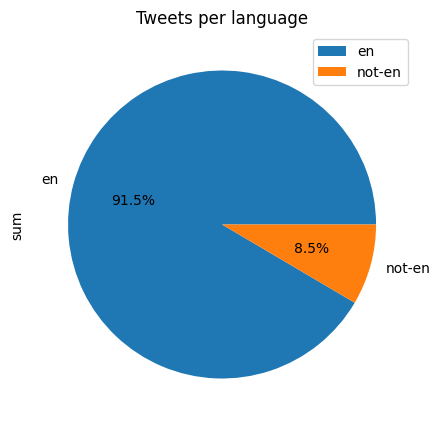

In [13]:
plot = df_grouped_total_lang.plot.pie(y='sum', title='Tweets per language', autopct='%1.1f%%', figsize=(5, 5))

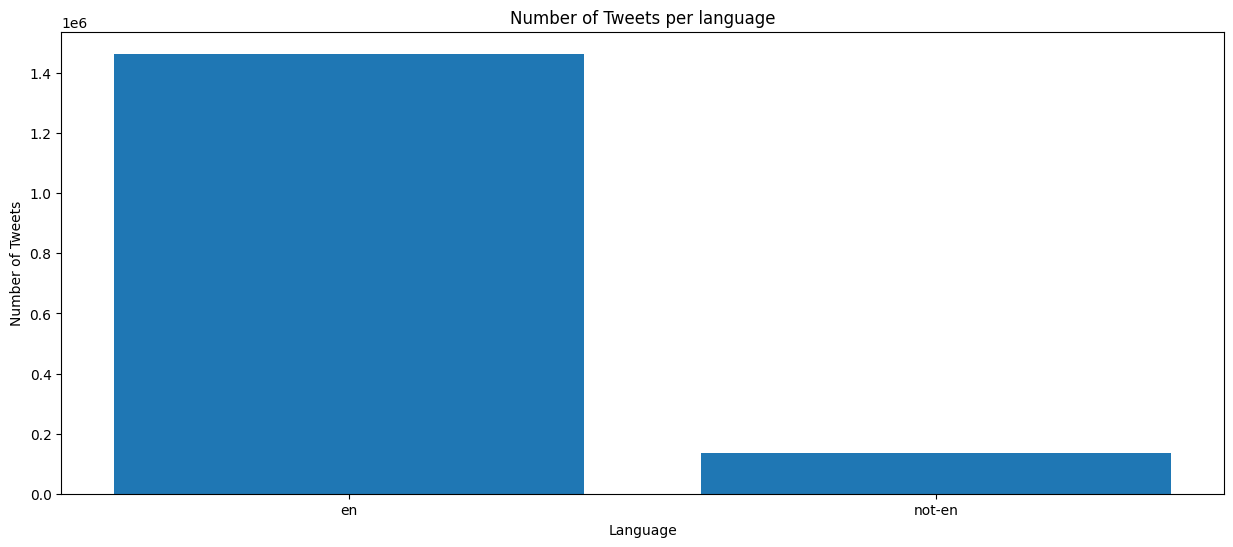

In [15]:
fig,ax=plt.subplots(figsize=(15,6))
ax.bar(df_grouped_total_lang.index, df_grouped_total_lang['sum'])

ax.set_xlabel('Language')
ax.set_ylabel('Number of Tweets')

ax.set_title('Number of Tweets per language')
plt.show()

##Pipeline: Delete not english tweets

In [11]:
df_en = df_pipe1[df_pipe1['language']== 'en']
df_en.reset_index(drop=True, inplace=True)
print(df_en.shape)
print(df_en['language'].unique())
df_en.head(10)

(1464303, 3)
['en']


,group,text,language
0,0,s a bummer. You shoulda got David Carr of T...,en
1,0,is upset that he can't update his Facebook by ...,en
2,0,I dived many times for the ball. Managed to s...,en
3,0,my whole body feels itchy and like its on fire,en
4,0,"no, it's not behaving at all. i'm mad. why am...",en
5,0,not the whole crew,en
6,0,Need a hug,en
7,0,"hey long time no see! Yes.. Rains a bit ,onl...",en
8,0,nope they didn't have it,en
9,0,spring break in plain city... it's snowing,en


##Step 5: Delete punctuation, stopwords, short words from tweets. Apply tokenization and stemming.

### punctuation - functions

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def remove_punctuation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned

class RemovePunctuationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_punctuation(x))
        return X_

###tokenization - functions

In [14]:
def tokenizer(text):
    #change to small letters
    lower_text = text.lower()
    #Tokenize
    tokenized_text = nltk.word_tokenize(lower_text)
    return tokenized_text
    
class TokenizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: tokenizer(x))
        return X_

### stopwords - functions

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords

class RemoveStopWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_stopwords(x))
        return X_

### short words - functions


In [17]:
def remove_short_tokens(text):
    without_short_tokens = [word for word in text if len(word) > 2]
    return without_short_tokens

class RemoveShortTokensTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_short_tokens(x))
        return X_

### stemming - functions

In [18]:
stemmer = nltk.PorterStemmer()

In [19]:
def stemming(text):
    stemwords = [stemmer.stem(word) for word in text]
    return stemwords

class StemmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: stemming(x))
        return X_

###Pipeline: Run deleting punctuation, stopwords and short words and apply tokenization and stemming

In [20]:
pipe2 = Pipeline(
    [('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
    ('tokenization', TokenizationTransformer(text_column='text')),
    ('remove_stop_words', RemoveStopWordsTransformer(text_column='text')),
    ('remove_short_tokens', RemoveShortTokensTransformer(text_column='text')),
    ('stemming', StemmingTransformer(text_column='text'))])


df_pipe2 = pipe2.fit_transform(df_en)
del df_en
df_pipe2.head(10)

,group,text,language
0,0,"[bummer, shoulda, got, david, carr, third, day]",en
1,0,"[upset, cant, updat, facebook, text, might, cr...",en
2,0,"[dive, mani, time, ball, manag, save, rest, bo...",en
3,0,"[whole, bodi, feel, itchi, like, fire]",en
4,0,"[behav, mad, cant, see]",en
5,0,"[whole, crew]",en
6,0,"[need, hug]",en
7,0,"[hey, long, time, see, ye, rain, bit, bit, lol...",en
8,0,"[nope, didnt]",en
9,0,"[spring, break, plain, citi, snow]",en


##Step 6: Return tweets as a string

In [21]:
def return_string(text):
    str_text = ' '.join(text)
    return str_text

class Return_String_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: return_string(x))
        return X_

In [22]:
pipe3 = Pipeline(
    [('return_string', Return_String_Transformer('text'))])


df_clean = pipe3.fit_transform(df_pipe2)
df_clean = df_clean[['group', 'text']]
#del df_pipe2
df_clean.head(10)

,group,text
0,0,bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest bound
3,0,whole bodi feel itchi like fire
4,0,behav mad cant see
5,0,whole crew
6,0,need hug
7,0,hey long time see ye rain bit bit lol fine tha...
8,0,nope didnt
9,0,spring break plain citi snow


# Split clean dataset into test and train subset

In [23]:
df_clean.shape

(1464303, 2)

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464303 entries, 0 to 1464302
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   group   1464303 non-null  int64 
 1   text    1464303 non-null  object
dtypes: int64(1), object(1)
memory usage: 22.3+ MB


In [25]:
df_clean['group'].value_counts()

0    737811
1    726492
Name: group, dtype: int64

In [26]:
# seperate dataset to X (features) and y (label)
y = df_clean.group
X = df_clean.text

In [27]:
# 50% of dataset to testing subset and 80% of dataset to training subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=2023, stratify=y)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(732151,)
(732152,)
(732151,)
(732152,)


# Vectorization (TF-IDF Vectorizer)

In [42]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features = 10000,  
    ngram_range=(1, 3), 
    stop_words='english'
    )

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.fit_transform(X_test)

In [48]:
# tfidf_vectorizer_pipeline = Pipeline(steps=[
#     ('tfidf_vectorizer', TfidfVectorizer(min_df=0.03, max_df=0.97, ngram_range=(1, 3)))
# ])

# X_train_vec = tfidf_vectorizer_pipeline.fit_transform(X_train)
# X_test_vec = tfidf_vectorizer_pipeline.fit_transform(X_test)

In [43]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(732151, 10000)
(732152, 10000)


# Models

##Logistic Regression

In [63]:
Log_reg = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
Log_reg.fit(X_train_vec, y_train)

#Evaluation
log_reg_y_pred = Log_reg.predict(X_test_vec)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.59      0.52      0.55    368906
           1       0.57      0.63      0.60    363246

    accuracy                           0.58    732152
   macro avg       0.58      0.58      0.58    732152
weighted avg       0.58      0.58      0.57    732152



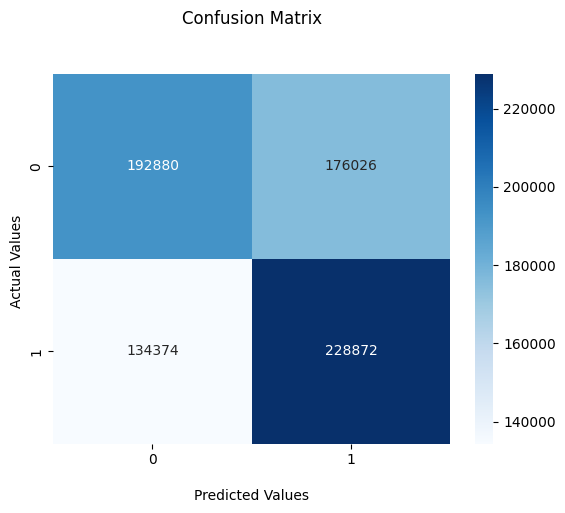

In [53]:
# Visualization: Confussion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()
    
plot_confusion_matrix(y_test, log_reg_y_pred)

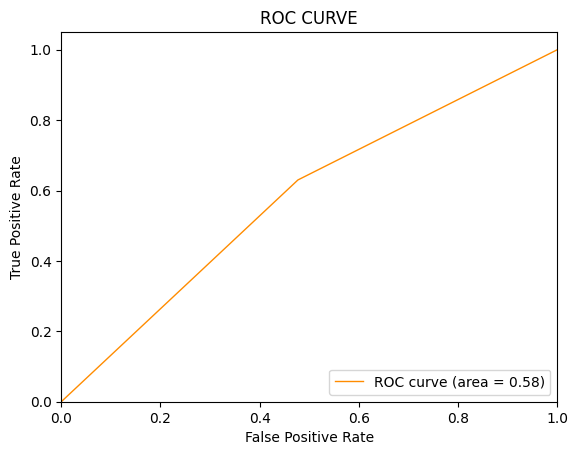

In [54]:
#Visualization: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

##SVC

In [55]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_vec, y_train)
svc_y_pred = SVCmodel.predict(X_test_vec)
print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55    368906
           1       0.56      0.62      0.59    363246

    accuracy                           0.57    732152
   macro avg       0.57      0.57      0.57    732152
weighted avg       0.57      0.57      0.57    732152



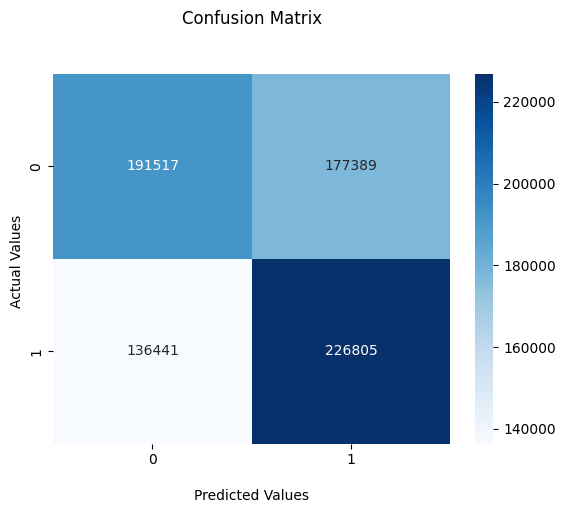

In [56]:
# Visualization: Confussion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()
    
plot_confusion_matrix(y_test, svc_y_pred)

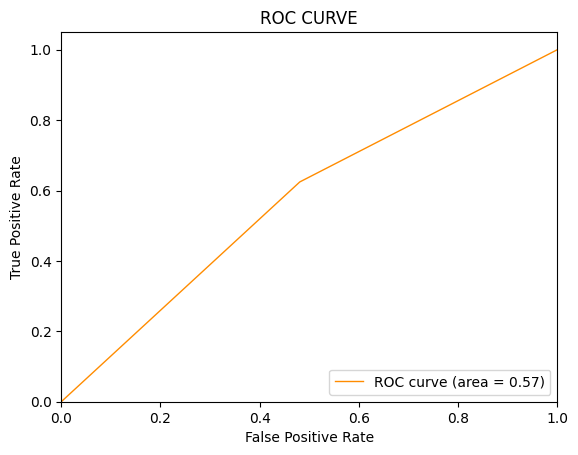

In [57]:
#Visualization: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, svc_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Decision tree

In [ ]:
decission_tree = DecisionTreeClassifier()
decission_tree.fit(X_train_vec, y_train)

#Evaluation
y_pred = decission_tree.predict(X_test_vec)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

In [ ]:
# Visualization: Confussion Matrix
plot_confusion_matrix(y_test, y_pred)

#Implementation

In [58]:
joblib.dump(Log_reg, '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/models_joblib/logistic_regression_5.pkl')

['/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/models_joblib/logistic_regression_5.pkl']

In [59]:
joblib.dump(SVCmodel, '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/models_joblib/svc_5.pkl')

['/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/models_joblib/svc_5.pkl']

In [ ]:
#joblib.dump(decission_tree, '/content/gdrive/MyDrive/Colab_Notebooks/PROJEKT_GRUPA_3/models_joblib/decission_tree.pkl')